In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


# STEP 1. 데이터 셋 구성하기

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
original_train_x = train_x
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


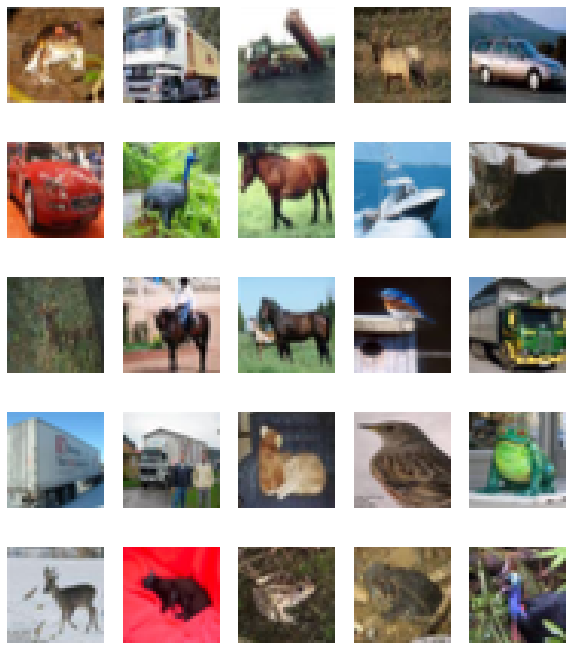

In [8]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(original_train_x[i])
    # plt.colorbar()
    plt.axis('off')

plt.show()

# STEP 2. 생성자 모델 구현하기

In [9]:
BUFFER_SIZE = 55000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
noise = tf.random.normal([1, 100])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [15]:
generated_image_plot = (generated_image + 1) / 2.0

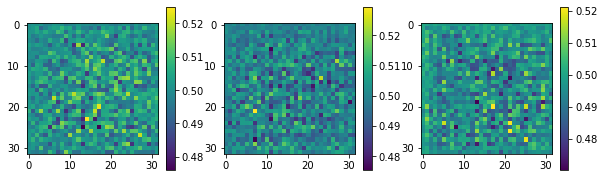

In [14]:
# plt.imshow(cv2.cvtColor(generated_image[0, :, :, 0], cv2.COLOR_BGR2RGB)) # , cmap='gray'
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(generated_image_plot[0, :, :, 0])
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(generated_image_plot[0, :, :, 1])
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(generated_image_plot[0, :, :, 2])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


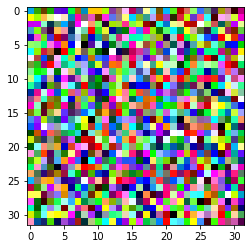

In [15]:
noise = tf.random.normal([32, 32, 3]) # -1 ~ 1
noise = (noise + 1) / 2.0 # 0 ~ 1
plt.imshow(noise)

# STEP 3. 판별자 모델 구현하기

In [16]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00620048]], dtype=float32)>

# STEP 4. 손실함수와 최적화 함수 구현하기

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 5. 훈련과정 상세 기능 구현하기

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :]) # , cmap='gray'
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

# STEP 6. 학습 과정 진행하기

In [16]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

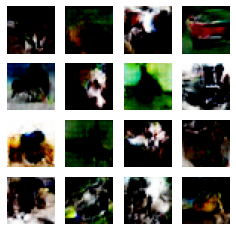

Time for training : 6088 sec


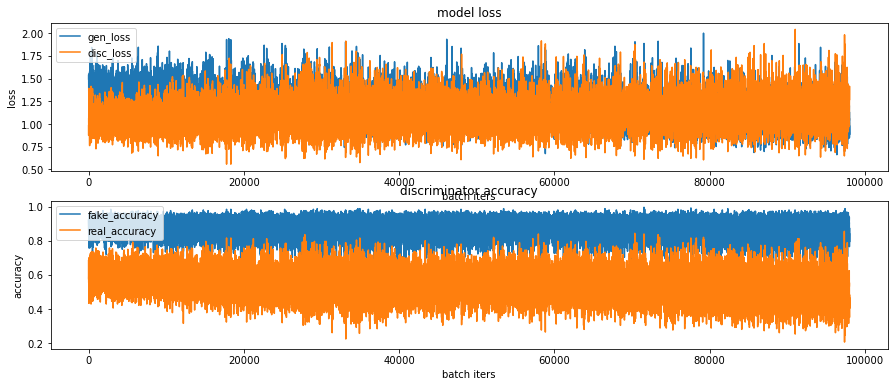

CPU times: user 1h 42min 21s, sys: 1min 57s, total: 1h 44min 18s
Wall time: 1h 41min 31s


In [113]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [114]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 ssac2 ssac2 3267904  2월 24 14:16 /home/ssac2/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif


### checkpoint 모듈을 활용해 모델을 로드하는 방법

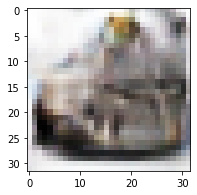

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/NODE_MODEL backup/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.figure(figsize = (3, 3))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# STEP 7. (optional) GAN 훈련 과정 개선하기

In [14]:
BUFFER_SIZE = 55000
BATCH_SIZE = 128     #256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2DTranspose layer
    # upsample to 8x8
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Sixth: Conv2DTranspose layer
    # model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.3))
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.4))
    
#     model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


generator = make_generator_model()
generator.summary()

discriminator = make_discriminator_model()
discriminator.summary()

# learning rate 변경
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)        

TensorShape([16, 100])

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :]) # , cmap='gray'
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()
    
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()
    
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [16]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50024825]], dtype=float32)>

In [17]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [31]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 ssac2 ssac2 3147663  2월 26 03:14 /home/ssac2/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif


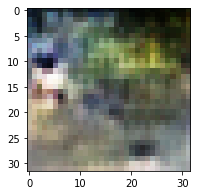

In [19]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.figure(figsize = (3, 3))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# 비교

- 기존 노드 모델로 진행
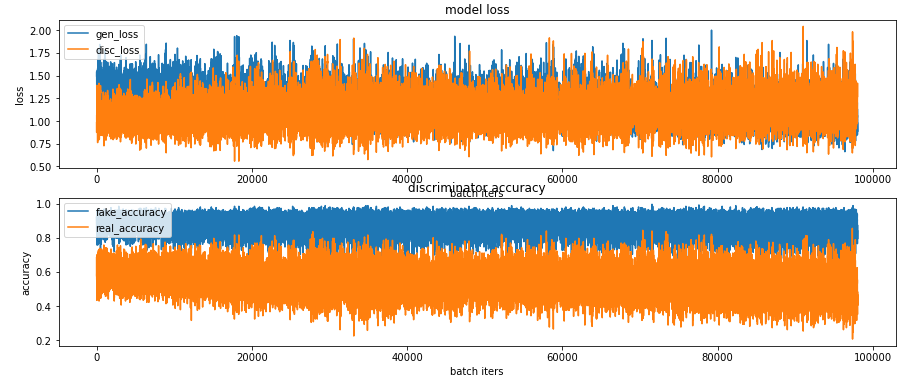

- 결과 사진
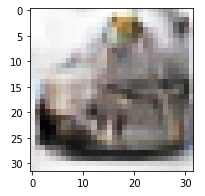

- 모델의 파라미터와 layer 수정
    
    1)
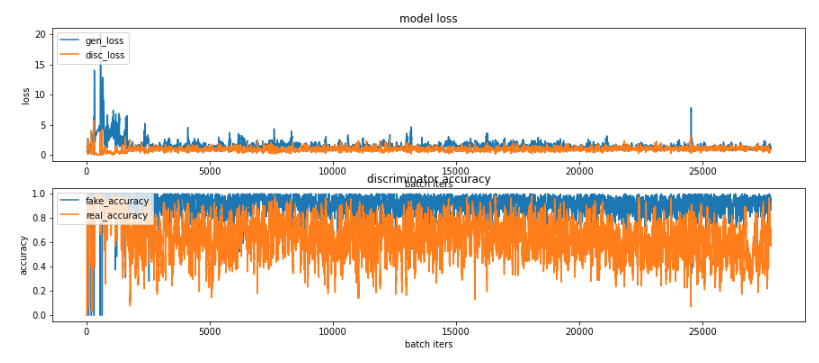
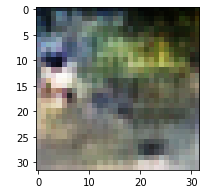

2)
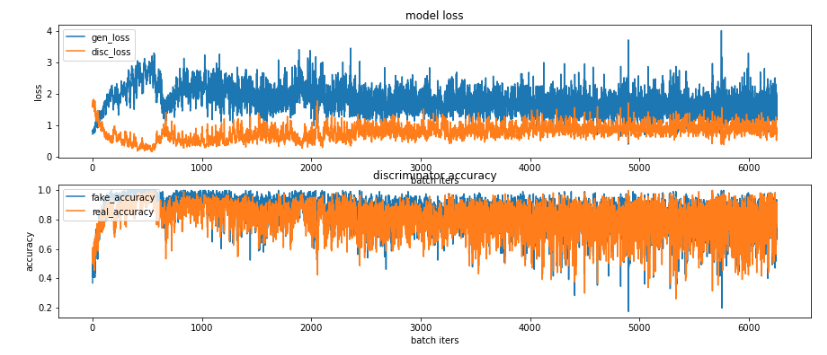
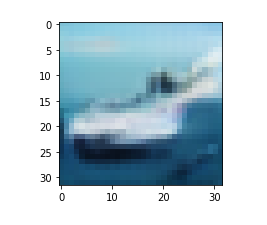
![Alt Text](./fashion_mnist_dcgan_제출.gif)

# 회고

## * 이번 프로젝트에서 어려웠던 점.
    확실히 GAN 내용이 어려운 것 같습니다.다른 프로젝트들은 그래도 어느 정도 노드에 기반한 내용으로 성능을 기대할 수 있었는데, 이번 GAN 모델은 노드대로 수행한 코드의 성능이 그렇게 좋지만은 않았습니다. 특히나 fake accuracy를 낮추려고 하면 판별자 모델의 loss가 높아지고, 또 바로잡으려고 하면 fake accuracy가 1에서 내려오지 않는 상황이 반복되어 쉽지 않았습니다. 그래도 최대한 모델의 파라미터 조정과 layer 수 조정 등으로 CIFAR-10 레이블에 존재하는 개체의 사진과 유사한 형태의 사진을 추출하기 위해 노력했습니다.
    

## * 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
    generator의 loss function을 binary cross-entropy를 사용하기보단 다른 loss function을 사용하면 성능을 더 좋게 가져갈 수도 있을 거라는 조언을 받았습니다. 그 조언에 따라 GAN에 사용되는 loss function을 하나 적용하여 프로젝트를 수행하려고 했는데, 학습하는 과정에서 차원이 계속 바뀌는 현상때문에 에러가 나서 그 부분에 대한 진행을 완료하지 못했습니다.
    

## * 루브릭 평가 지표를 맞추기 위해 시도한 것들.
1) GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다. 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였는가?
    
    Yes. CIFAR-10에는 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭 10개의 레이블이 존재합니다. GAN을 이용하여 생성한 이미지 중에서 모델의 파라미터와 layer의 수 조정, activation 함수 설정 등으로 추출한 이미지 중에서 배와 유사한 그림을 생성하였고, 학습 도중에 CIFAR-10에 존재하는 레이블 중 새와 배, 말에 해당하는 그림이 생성되는 과정을 보기도 하였습니다. (gif파일 참조)
        
        
2) 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다. gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였는가?
    
    gif를 통해서 생성 이미지 품질이 서서히 향상되는 과정과 accuracy, loss에 대한 그래프를 출력해보았습니다. 하지만, 추세적으로 0.5를 향해가는지는 real accuracy 그래프에 가려 정확히 판단하기가 어렵습니다. (그래프가 너무 위 아래로 폭이 크고, generator loss가 생각 이상으로 큰 점 때문에 모델 학습이 잘 이루어졌다고 보기는 힘들 것 같습니다.)
    

3) 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다. 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 적용 이전보다 향상되었음을 시각적으로 입증하였는가?
    
    기존 노드에서 진행한 모델 대신에 모델의 파라미터 값 수정, layer 추가 및 activation function 설정 등 여러가지 부분을 변경해보면서 각각에 대한 모델 성능을 비교해보았습니다. 해당 결과가 적용 이전보다 향상되었음을 최종 산출물과 학습과정 그래프를 통해 시각적으로 입증하였습니다. 
